In [1]:
#Install necessary libraries
!pip install SpeechRecognition
!pip install pydub
!pip install spacy
!pip install nltk
!python3 -m spacy download en_core_web_sm

No se encontr� Python; ejecuta sin argumentos para instalar desde Microsoft Store o deshabilita este acceso directo en Configuraci�n > Administrar alias de ejecuci�n de la aplicaci�n.


In [2]:
# Import required libraries
import pandas as pd
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import speech_recognition as sr
from pydub import AudioSegment
import spacy
from matplotlib import pyplot as plt
import seaborn as sns   

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Gabriel\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
c:\Users\Gabriel\AppData\Local\Programs\Python\Python311\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


Transcribing and analysing sample customer call.

In [3]:
#transcribe audio
recognizer = sr.Recognizer()
sample_customer_call = sr.AudioFile(r'sample_customer_call.wav')
with sample_customer_call as source:
    sample_customer_call_data = recognizer.record(source)

transcribed_text = recognizer.recognize_google(sample_customer_call_data)
print(f"Transcription: {transcribed_text}")

#import and analyzing audio
wav_file = AudioSegment.from_file(r'sample_customer_call.wav')
frame_rate = wav_file.frame_rate
number_channels = wav_file.channels
print(f'Frame rate: {frame_rate}\nNumber of channels: {number_channels}')

Transcription: hello I'm experiencing an issue with your product I'd like to speak to someone about a replacement
Frame rate: 44100
Number of channels: 1


Importing customer call transcriptions and analyzing them with VADER lexicon. Assigning a label based on the 'compound' score.

(102, 2)


,text,sentiment_label
0,how's it going Arthur I just placed an order w...,negative
1,yeah hello I'm just wondering if I can speak t...,neutral
2,hey I receive my order but it's the wrong size...,negative
3,hi David I just placed an order online and I w...,neutral
4,hey I bought something from your website the o...,negative


,text,sentiment_label,polarity_score_compound,sentiment
0,how's it going Arthur I just placed an order w...,negative,-0.128,negative
1,yeah hello I'm just wondering if I can speak t...,neutral,0.296,positive
2,hey I receive my order but it's the wrong size...,negative,-0.296,negative
3,hi David I just placed an order online and I w...,neutral,0.000,neutral
4,hey I bought something from your website the o...,negative,0.000,neutral


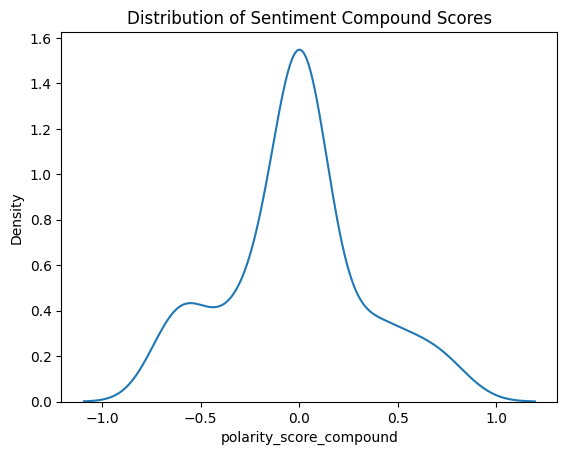

In [4]:
df = pd.read_csv(r'customer_call_transcriptions.csv')
print(df.shape)
display(df.head())

sid = SentimentIntensityAnalyzer()
df['polarity_score_compound'] = df['text'].apply(lambda x:sid.polarity_scores(x)['compound'])

def classify(score):
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"
    
df['sentiment'] = df['polarity_score_compound'].apply(classify)
display(df.head())

sns.kdeplot(df['polarity_score_compound'])
plt.title('Distribution of Sentiment Compound Scores')
plt.show()

Finding most frequent entities appling NER with spaCy model.

In [5]:
nlp = spacy.load("en_core_web_md")
entity_dict = {}

for text in df['text']:
    doc = nlp(text)
    for ent in doc.ents:
        if ent.text in entity_dict:
            entity_dict[ent.text] += 1
        else:
            entity_dict[ent.text] = 1

#convert dictionary to dataframe and sorting
entity_df = pd.DataFrame({"entity": entity_dict.keys(), "count": entity_dict.values()}).sort_values(by='count', ascending=False)
display(entity_df.head())

,entity,count
1,yesterday,15
5,this morning,5
15,two,4
3,the other day,3
9,Jacob,2


Searching for most similar context to the phrase: "wrong package delivered".

In [6]:
input_query = 'wrong package delivery'
processed_query = nlp(input_query)
df['similarity'] = df['text'].apply(lambda x: processed_query.similarity(nlp(x)))

pd.set_option('display.max_colwidth', None)
display(df.sort_values(by='similarity', ascending=False).head())


,text,sentiment_label,polarity_score_compound,sentiment,similarity
81,wrong package delivered,negative,-0.4767,negative,0.936430
58,I purchase something from your online store yesterday but the receipt didn't come through can can I get another receipt emailed please,negative,0.4497,positive,0.653603
28,is there anybody that can help me set up this product or any how to use,neutral,0.4019,positive,0.641127
45,hi Jacob I just placed an order with you guys but I found the same product online at another store for a cheaper price I was wondering if you could price match it or could I cancel this order,neutral,-0.3612,negative,0.638241
90,what's your refund policy on items that I've purchased from you guys,neutral,0.0000,neutral,0.635387


Please refer to the README file for more possible enhancements to this project
